In [41]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

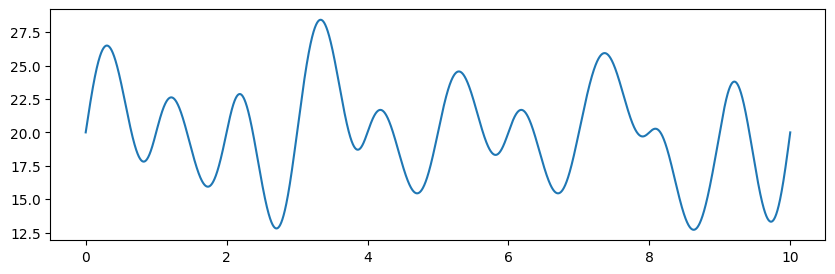

In [48]:
class PerlinNoiseGenerator:
    def __init__(self, n_iter, timescale, noise_factor: int = 1):
        self.baseline  = 20
        self.scaling   = 5
        self.n_iter    = n_iter
        self.timescale = timescale

    def fade(self, t):
        """Fade function as defined by Ken Perlin."""
        return t * t * t * (t * (t * 6 - 15) + 10)

    def lerp(self, a, b, x):
        """Linear interpolation."""
        return a + x * (b - a)

    def grad(self, hash_value, x):
        """Gradient function."""
        h = hash_value & 15
        grad = 1 + (h & 7)  # Gradient value is one of 1, 2, ..., 8
        return (grad * x)  # Compute the dot product

    # Create a permutation array
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()  # Duplicate to avoid overflow

    def perlin(self, x):
        """Generate Perlin noise for input x."""
        X = int(x) & 255
        x -= int(x)
        u = self.fade(x)
        
        a = p[X]
        b = p[X + 1]

        return self.lerp(self.grad(a, x), self.grad(b, x - 1), u)
    
    def generate(self):
        # Example of using the Perlin noise generator to produce temperature variations
        time_steps = np.linspace(0, self.timescale, self.n_iter)
        outdoor_temperatures = [20 + self.scaling*self.perlin(t) for t in time_steps]
        return time_steps, outdoor_temperatures

time_steps, outdoor_temps = PerlinNoiseGenerator(10001, 10, 1).generate()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(time_steps, outdoor_temps)
plt.show()

In [49]:
# Constants
class Environment: 
    TEMPERATURE_GOAL = 21.0  # desired temperature in Celsius
    ACTION_SCALE = 5.0  # amount of heating/cooling applied per action unit
    
    def __init__(self, outdoor_temps, init_temp):
        self.outdoor_temps = outdoor_temps
        self.curr_outdoor_temp = outdoor_temps[0]
        self.curr_indoor_temp  = init_temp
        self.curr_time         = 0
    
    def update_indoor_temperature(self, power):
        """Update indoor temperature based on outdoor temperature and applied power."""
        # Here, 0.05 is an arbitrary coefficient showing influence of outdoor temp on indoor temp
        # 0.1 is another coefficient showing influence of power
        # (heating/cooling) on indoor temp
        self.curr_indoor_temp = self.curr_indoor_temp \
            + 0.05 * (self.curr_outdoor_temp - self.curr_indoor_temp) + \
            + 0.10 * power \
            + np.random.normal(0, 0.2)
        
        self.curr_time += 1
        self.curr_outdoor_temp = self.outdoor_temps[self.curr_time]
            
        return self.curr_time, self.curr_indoor_temp, self.curr_outdoor_temp

Step 1: Current Temp: 19.47, Outdoor Temp: 20.03, Chosen Action: -1.00, Power: -5.00
Step 1001: Current Temp: 9.21, Outdoor Temp: 20.02, Chosen Action: -1.00, Power: -5.00
Step 2001: Current Temp: 15.80, Outdoor Temp: 20.02, Chosen Action: -0.40, Power: -2.00
Step 3001: Current Temp: 19.95, Outdoor Temp: 20.04, Chosen Action: 0.10, Power: 0.50
Step 4001: Current Temp: 21.22, Outdoor Temp: 20.01, Chosen Action: 0.70, Power: 3.50
Step 5001: Current Temp: 21.01, Outdoor Temp: 20.02, Chosen Action: 0.00, Power: 0.00
Step 6001: Current Temp: 21.13, Outdoor Temp: 20.01, Chosen Action: 1.00, Power: 5.00
Step 7001: Current Temp: 21.22, Outdoor Temp: 20.02, Chosen Action: 0.30, Power: 1.50
Step 8001: Current Temp: 20.77, Outdoor Temp: 20.00, Chosen Action: 0.30, Power: 1.50
Step 9001: Current Temp: 20.72, Outdoor Temp: 20.03, Chosen Action: -0.50, Power: -2.50


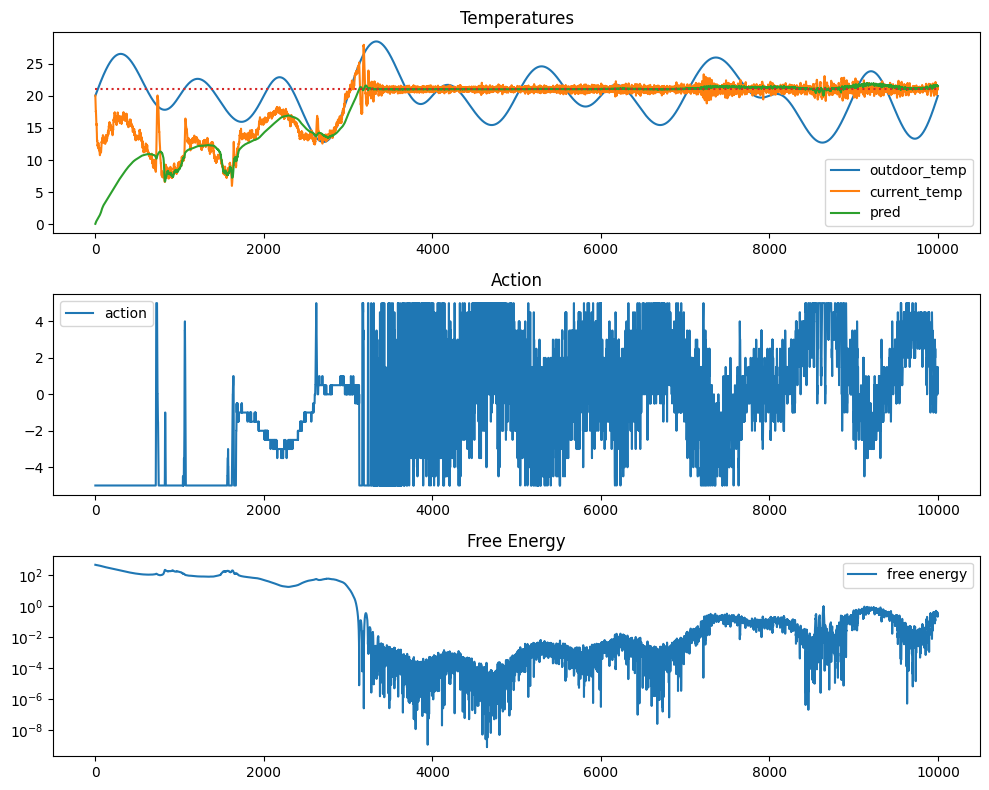

In [50]:
# Define RNN model
class ThermostatRNN(nn.Module):
    def __init__(self, optimal_temp = 21.0, lr=0.001):
        super(ThermostatRNN, self).__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=20, num_layers=1, batch_first=True)  # input size increased to 3
        self.fc = nn.Linear(20, 2)
        self.optimal_temp = optimal_temp
        
        # Learning Functions
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.MSELoss()


    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

    def free_energy(self, predicted, observed):
        """Calculate the free energy, which is the discrepancy between predicted and observed."""
        return self.criterion(predicted, observed)

    def train_step(self, current_temp, outdoor_temp, action, next_temp):
        """Training step for the RNN."""
        self.optimizer.zero_grad()
        predicted = model(torch.FloatTensor([[current_temp, outdoor_temp, action]]).unsqueeze(0))
        predicted_next_temp = predicted[0, 0, 0]
        loss = self.free_energy(predicted_next_temp, next_temp)
        loss.backward()
        self.optimizer.step()
        return loss

    def choose_action(self, current_temp, outdoor_temp):
        """Choose an action based on minimizing predicted free energy."""
        best_action = 0
        lowest_free_energy = float('inf')

        for potential_action in np.linspace(-1, 1, 21):  # considering 21 potential actions from -1 to 1
            predicted = model(
                torch.FloatTensor([[current_temp, outdoor_temp, potential_action]]).unsqueeze(0)
            )
            predicted_temp = predicted[0,0,0]
            fe = self.free_energy(
                predicted = predicted_temp,
                observed  = torch.tensor(self.optimal_temp, dtype=torch.float32)
            )
            if fe.item() < lowest_free_energy:
                best_action = potential_action
                lowest_free_energy = fe.item()

        return best_action, predicted[0, 0, 0], fe.detach()

# Initialize Environment
env       = Environment(outdoor_temps, init_temp=20.0)
model     = ThermostatRNN(env.TEMPERATURE_GOAL, lr=0.001)
states = []

for step in range(10000):
    orig_indoor_temp  = env.curr_indoor_temp
    orig_outdoor_temp = env.curr_outdoor_temp
    

    action, pred_indoor_temp, free_energy = model.choose_action(orig_indoor_temp, orig_outdoor_temp)
    power = action * env.ACTION_SCALE
    env.update_indoor_temperature(power)
    
    model.train_step(
        orig_indoor_temp,
        orig_outdoor_temp,
        action,
        torch.tensor(env.curr_indoor_temp, dtype=torch.float32)
    )
     
    if step % 1000 == 0:
        print(f"Step {step+1}: Current Temp: {env.curr_indoor_temp:.2f}, Outdoor Temp: {env.curr_outdoor_temp:.2f}, Chosen Action: {action:.2f}, Power: {power:.2f}")
    
    states.append((
        orig_outdoor_temp,
        orig_indoor_temp,
        pred_indoor_temp.detach(),
        power,
        free_energy
    ))
    
states = np.array(states)

import matplotlib.pyplot as plt

# Assuming states is a numpy array or similar with the described structure
# Initialize a figure with 2 subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

# plot 1: temperatures on the first subplot (ax[0])
ax[0].plot(states[:, 0], label="outdoor_temp")
ax[0].plot(states[:, 1], label="current_temp")
ax[0].plot(states[:, 2], label="pred")
ax[0].plot([0, len(states)], [env.TEMPERATURE_GOAL, env.TEMPERATURE_GOAL], ":")
ax[0].set_title("Temperatures")
ax[0].legend()

# plot 2: action on the second subplot (ax[1])
ax[1].plot(states[:, 3], label="action")
ax[1].set_title("Action")
ax[1].legend()

# plot 3: Free Energy
ax[2].semilogy(states[:, 4], label="free energy")
ax[2].set_title("Free Energy")
ax[2].legend()

plt.tight_layout()
plt.show()